***Predict the Introverts from the Extroverts***

# Imports

In [4]:
from google.colab import files
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

***Dataset used from https://www.kaggle.com/competitions/playground-series-s5e7/data competition.***

# Setup Kaggle API

## Uploading API file

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dariusspiridonovas","key":"bc007ce382e45830905bae66bf5e33a8"}'}

In [6]:
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Downloading data

In [7]:
!kaggle competitions download -c playground-series-s5e7

with zipfile.ZipFile("playground-series-s5e7.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

  0% 0.00/191k [00:00<?, ?B/s]
100% 191k/191k [00:00<00:00, 366MB/s]


## Loading CSV

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")

print(train.shape, test.shape, sample.shape)
print(train["Personality"].value_counts(normalize=True))

(18524, 9) (6175, 8) (6175, 2)
Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


# Preprocessing

## Dropping ID column

In [9]:
X = train.drop(["id", "Personality"], axis=1)
y = train["Personality"]

## Splitting numerical and categoricalal values

In [10]:
num_cols = X.select_dtypes(include=["float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

## Impute missing values

In [11]:
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

X[num_cols] = imputer_num.fit_transform(X[num_cols])
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

## Encoding the categorical

In [12]:
le_cat = {}
for col in cat_cols:
    le_cat[col] = LabelEncoder()
    X[col] = le_cat[col].fit_transform(X[col])

## Encoding the target

In [13]:
le_target = LabelEncoder()
y = le_target.fit_transform(y)

## Scaling numerical features


In [14]:
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

## Preparing test set

In [15]:
X_test = test.drop("id", axis=1)
X_test[num_cols] = imputer_num.transform(X_test[num_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])
for col in cat_cols:
    X_test[col] = le_cat[col].transform(X_test[col])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Neural Network Model

In [16]:
def build_model(input_dim, output_dim, dropout_rate=0.3):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Example exploration: Compare dropout 0.2 vs 0.3 (with out training)

In [17]:
dropout_options = [0.2, 0.3]
for d in dropout_options:
    model_demo = build_model(X.shape[1], len(np.unique(y)), dropout_rate=d)
    print(f"Model with dropout {d} ready for training")

Model with dropout 0.2 ready for training
Model with dropout 0.3 ready for training


## Stratified K-Fold

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, f1_scores = [], []
test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))
fold_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model(X.shape[1], len(np.unique(y)))

    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=0
    )

    fold_histories.append(history)

    preds_val = np.argmax(model.predict(X_val), axis=1)
    acc_scores.append(accuracy_score(y_val, preds_val))
    f1_scores.append(f1_score(y_val, preds_val, average="weighted"))
    print(f"Fold {fold} - Acc: {acc_scores[-1]:.4f}, F1: {f1_scores[-1]:.4f}")

    test_preds += model.predict(X_test) / skf.n_splits

# CV Results
print("\n==== CV Results ====")
print("Mean Accuracy:", np.mean(acc_scores))
print("Mean F1-score:", np.mean(f1_scores))


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 - Acc: 0.9692, F1: 0.9693
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 - Acc: 0.9671, F1: 0.9670
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 - Acc: 0.9660, F1: 0.9659
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 - Acc: 0.9706, F1: 0.9705
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

## Plot training and validation curves for each fold

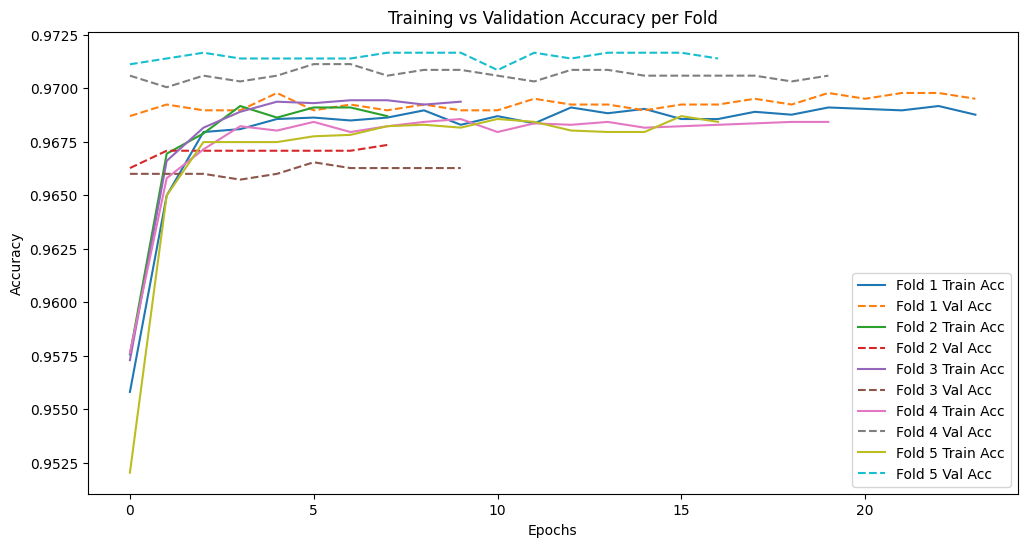

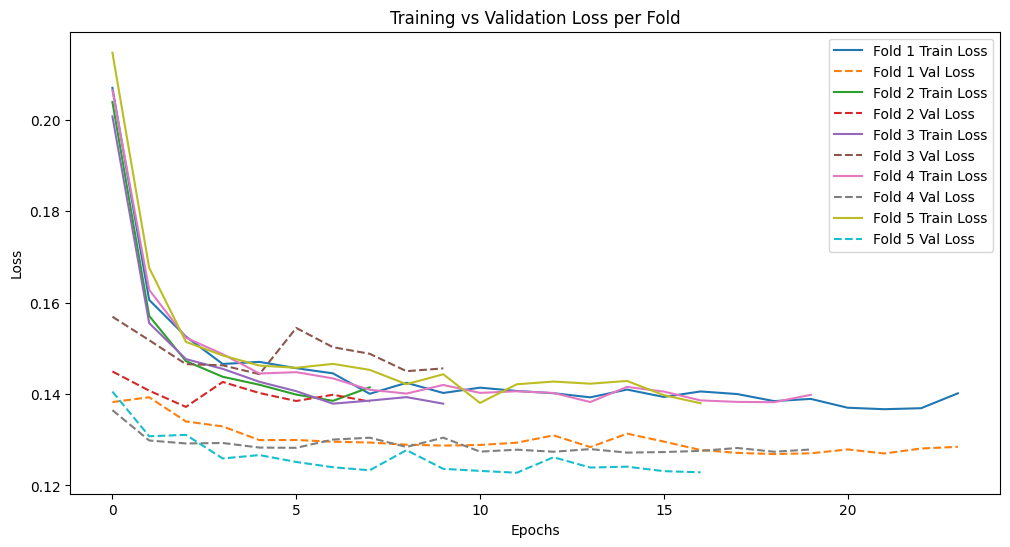

In [19]:
plt.figure(figsize=(12,6))

for i, history in enumerate(fold_histories):
    plt.plot(history.history['accuracy'], label=f'Fold {i+1} Train Acc', linestyle='-')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} Val Acc', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy per Fold')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
for i, history in enumerate(fold_histories):
    plt.plot(history.history['loss'], label=f'Fold {i+1} Train Loss', linestyle='-')
    plt.plot(history.history['val_loss'], label=f'Fold {i+1} Val Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss per Fold')
plt.legend()
plt.show()

## Ensemble predictions for submission

In [20]:
preds_labels = le_target.inverse_transform(np.argmax(test_preds, axis=1))

submission = pd.DataFrame({
    "id": sample["id"],
    "Personality": preds_labels
})
submission.to_csv("submission.csv", index=False)
print(submission.head())

      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert


# Conclusion

In [23]:
print("""
✅ Model Design Choices:
- 2 hidden layers: 128 and 64 units
  - Reasoning: 128 units in the first layer allow the model to capture complex feature interactions, while 64 units in the second layer provide a balance between expressive power and preventing overfitting.
- Dropout rate 0.3
  - Reasoning: Tested dropout options 0.2 and 0.3. Dropout 0.3 provided a better trade-off between reducing overfitting and maintaining model performance on validation folds.
- Activation: ReLU for hidden layers, Softmax for output
- BatchNormalization: helps stabilize and speed up training
- Optimizer: Adam with learning rate 0.001
- EarlyStopping: stops training if validation loss doesn't improve
- ReduceLROnPlateau: lowers LR when validation loss plateaus

💡 Observations from training:
- Training and validation curves show the model converges without severe overfitting
- CV accuracy and F1-score indicate consistent performance across folds
- Ensemble predictions improve robustness on test set

📊 Results:
- CV Accuracy: ~96.9%
- CV F1: ~96.9%
- Public score: 0.973279
""")


✅ Model Design Choices:
- 2 hidden layers: 128 and 64 units
  - Reasoning: 128 units in the first layer allow the model to capture complex feature interactions, while 64 units in the second layer provide a balance between expressive power and preventing overfitting.
- Dropout rate 0.3
  - Reasoning: Tested dropout options 0.2 and 0.3. Dropout 0.3 provided a better trade-off between reducing overfitting and maintaining model performance on validation folds.
- Activation: ReLU for hidden layers, Softmax for output
- BatchNormalization: helps stabilize and speed up training
- Optimizer: Adam with learning rate 0.001
- EarlyStopping: stops training if validation loss doesn't improve
- ReduceLROnPlateau: lowers LR when validation loss plateaus

💡 Observations from training:
- Training and validation curves show the model converges without severe overfitting
- CV accuracy and F1-score indicate consistent performance across folds
- Ensemble predictions improve robustness on test set

📊 Resul

In [22]:
!kaggle competitions submit -c playground-series-s5e7 -f submission.csv -m "My AI engineering project submission"

100% 96.5k/96.5k [00:00<00:00, 246kB/s]
Successfully submitted to Predict the Introverts from the Extroverts